# Imports

In [2]:
import pandas as pd
from feature_engine.timeseries.forecasting import LagFeatures

from ForecastEvaluator import ForecastEvaluator
from _config import PKL_PROCESSED_STEP2_DTU_SOLAR_STATION

# Load (Preprocessed Step 1) DTU Solar Station data

In [3]:
df = pd.read_pickle(PKL_PROCESSED_STEP2_DTU_SOLAR_STATION)
df = df[sorted(df.columns)]
full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq="1min")
df = df.reindex(full_range)
df.sort_index(inplace=True)
# make all nan values zero
df.fillna(0, inplace=True)
df_raw = df.copy()

print(df.shape)
print(df.info())
df.head()

(5156794, 13)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5156794 entries, 2015-03-14 05:31:00 to 2025-01-01 08:04:00
Freq: min
Data columns (total 13 columns):
 #   Column             Dtype  
---  ------             -----  
 0   DHI                float64
 1   DNI                float64
 2   DNI_lag_1440       float64
 3   DNI_lag_2880       float64
 4   DNI_lag_60         float64
 5   air_pressure       float64
 6   air_temperature    float64
 7   rain_duration      float64
 8   rain_intensity     float64
 9   relative_humidity  float64
 10  solar_altitude     float64
 11  wind_dir_avg       float64
 12  wind_speed_avg     float64
dtypes: float64(13)
memory usage: 550.8 MB
None


,DHI,DNI,DNI_lag_1440,DNI_lag_2880,DNI_lag_60,air_pressure,air_temperature,rain_duration,rain_intensity,relative_humidity,solar_altitude,wind_dir_avg,wind_speed_avg
2015-03-14 05:31:00,1.291,0.074599,0.000000,0.0,0.0,1027.0,1.4,0.0,0.0,74.2,0.026399,62.0,1.2
2015-03-14 05:32:00,1.468,0.068680,0.000000,0.0,0.0,1027.0,1.4,0.0,0.0,74.2,0.142481,59.0,2.6
2015-03-14 05:33:00,1.730,0.098285,0.000000,0.0,0.0,1027.0,1.4,0.0,0.0,74.2,0.259842,46.0,3.3
2015-03-14 05:34:00,2.021,0.100610,0.000000,0.0,0.0,1027.0,1.4,0.0,0.0,74.2,0.378417,43.0,3.5
2015-03-14 05:35:00,2.319,0.086447,0.005921,0.0,0.0,1027.0,1.4,0.0,0.0,74.2,0.498142,42.0,2.1


In [4]:
from data_loader import MyDataLoader
from _config import PATH_TO_CONFIG
from my_config import load_config, MyConfig

my_config: MyConfig = load_config(PATH_TO_CONFIG)
data_loader = MyDataLoader(my_config)
data_loader.load_data()
data_loader.lag_features()
data_loader.prepare_df()
df_all = data_loader.get_df()
df_all

,DNI,DNI_lag_60,DNI_lag_1440,DNI_lag_2880
2015-03-14 05:31:00,0.074599,0.0,0.000000,0.0
2015-03-14 05:32:00,0.068680,0.0,0.000000,0.0
2015-03-14 05:33:00,0.098285,0.0,0.000000,0.0
2015-03-14 05:34:00,0.100610,0.0,0.000000,0.0
2015-03-14 05:35:00,0.086447,0.0,0.005921,0.0
...,...,...,...,...
2025-01-01 08:00:00,0.000000,0.0,0.000000,0.0
2025-01-01 08:01:00,0.000000,0.0,0.000000,0.0
2025-01-01 08:02:00,0.000000,0.0,0.000000,0.0
2025-01-01 08:03:00,0.000000,0.0,0.000000,0.0


In [ ]:
TARGETS = [x.name for x in my_config.target_variables]
X_all = df_all.drop(columns=TARGETS)
y_all = df_all[TARGETS]
X_test = X_all.loc['2024']
y_test = y_all.loc['2024']

# Datasplitting

# ARIMA model

In [95]:
df = df_raw.copy() # Take 1 month
df.loc[:, 'DNI_lag60'] = df['DNI'].shift(60)
df.loc[:, 'DNI_lag1440'] = df['DNI'].shift(1440)
df.loc[:, 'DNI_lag1440x2'] = df['DNI'].shift(1440*2)
df = df.dropna()

df

,DHI,DNI,air_pressure_lag_60,air_temperature_lag_60,rain_duration_lag_60,rain_intensity_lag_60,relative_humidity_lag_60,solar_altitude_lag_60,wind_dir_avg_lag_60,wind_speed_avg_lag_60,DNI_lag60,DNI_lag1440,DNI_lag1440x2
2015-03-14 06:36:00,78.17,0.274684,1027.0,1.4,0.0,0.0,74.2,0.618954,59.0,3.3,0.105401,469.414253,550.361984
2015-03-14 06:37:00,79.79,0.303131,1027.0,1.4,0.0,0.0,74.1,0.740793,66.0,3.1,0.099472,105.500988,556.151177
2015-03-14 06:38:00,81.22,0.312613,1027.0,1.4,0.0,0.0,74.1,0.863601,31.0,2.5,0.112488,493.669103,563.337782
2015-03-14 06:39:00,82.67,0.290156,1027.0,1.5,0.0,0.0,74.0,0.987321,53.0,4.2,0.097097,41.611550,569.626158
2015-03-14 06:40:00,84.03,0.282969,1027.0,1.5,0.0,0.0,73.8,1.111899,59.0,3.1,0.118377,157.503081,575.615184
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-01 08:00:00,0.00,0.000000,1007.0,7.1,0.0,0.0,79.2,3.714686,239.0,3.6,0.000000,0.000000,0.000000
2025-01-01 08:01:00,0.00,0.000000,1007.0,7.1,0.0,0.0,79.2,3.631381,259.0,5.4,0.000000,0.000000,0.000000
2025-01-01 08:02:00,0.00,0.000000,1007.0,7.1,0.0,0.0,79.3,3.547774,223.0,3.8,0.000000,0.000000,0.000000
2025-01-01 08:03:00,0.00,0.000000,1007.0,7.1,0.0,0.0,79.4,3.463873,230.0,3.7,0.000000,0.000000,0.000000


In [96]:
df_sub = df.loc['2023'].copy() # Take 1 month
df_sub

,DHI,DNI,air_pressure_lag_60,air_temperature_lag_60,rain_duration_lag_60,rain_intensity_lag_60,relative_humidity_lag_60,solar_altitude_lag_60,wind_dir_avg_lag_60,wind_speed_avg_lag_60,DNI_lag60,DNI_lag1440,DNI_lag1440x2
2023-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-01 00:01:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-01 00:02:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-01 00:03:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-01 00:04:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 23:55:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-12-31 23:56:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-12-31 23:57:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-12-31 23:58:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [97]:
import pandas as pd
import statsmodels.api as sm
# add lag 60 minutes and 1440 minutes


model = sm.OLS(df['DNI'], df[['DNI_lag60', 'DNI_lag1440', 'DNI_lag1440x2']])
res_ols = model.fit()

print(res_ols.summary())
# res_ols.params['y_lag60'] is your φ60


                                 OLS Regression Results                                
Dep. Variable:                    DNI   R-squared (uncentered):                   0.676
Model:                            OLS   Adj. R-squared (uncentered):              0.676
Method:                 Least Squares   F-statistic:                          3.593e+06
Date:                Fri, 25 Apr 2025   Prob (F-statistic):                        0.00
Time:                        17:47:31   Log-Likelihood:                     -3.3452e+07
No. Observations:             5156729   AIC:                                  6.690e+07
Df Residuals:                 5156726   BIC:                                  6.690e+07
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

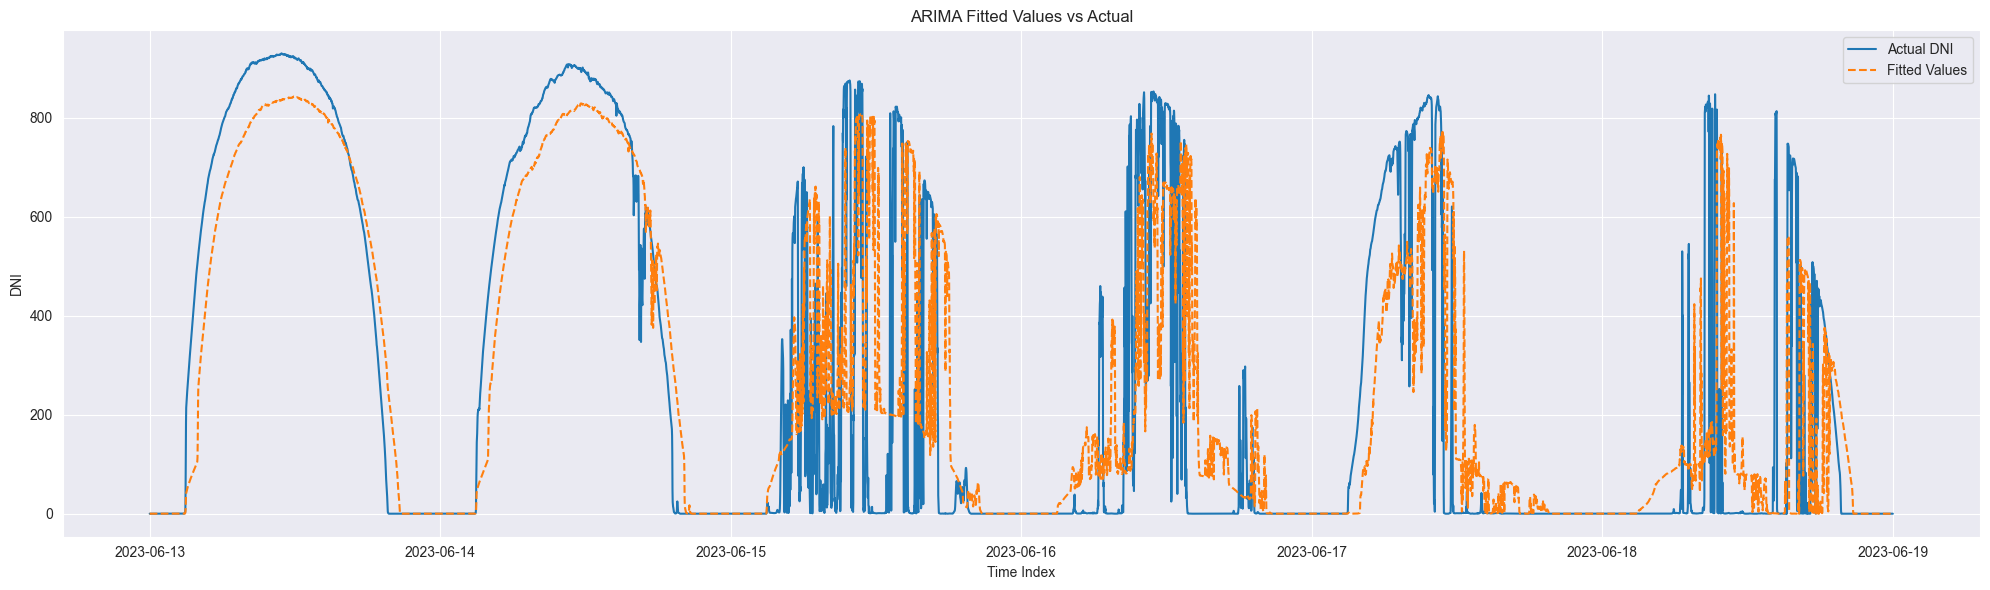

In [98]:
start = '2023-06-13'
end = '2023-06-18'
fitted_values = res_ols.fittedvalues
# Plot fitted values
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 6))
plt.plot(df.loc[start:end].index, df.loc[start:end]['DNI'], label='Actual DNI')
plt.plot(df.loc[start:end].index, fitted_values.loc[start:end], label='Fitted Values', linestyle='--')
plt.title('ARIMA Fitted Values vs Actual')
plt.xlabel('Time Index')
plt.ylabel('DNI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()